### Análise de Séries Temporais – Óbitos Mensais (SIM)
**Modelos:** SARIMA, Holt-Winters e LSTM  
**Autor:** Vitor Amadeu

# 1. IMPORTAÇÕES

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from tensorflow.keras.optimizers import Adam, AdamW

c:\Users\Vitor\anaconda3\envs\Jupyter_R\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


# 2. FUNÇÕES AUXILIARES

In [3]:
def carregar_series_temporal(caminho_csv: str) -> pd.Series:
    """
    Carrega o dataset combinado e retorna a série temporal mensal de óbitos.
    """
    df = pd.read_csv(
    'D:/Analise_de_dados_SIM/Data/processed/dataset_I219_analise_descritiva.csv',
    sep=',',
    encoding='latin1',
    low_memory=False,
    on_bad_lines='warn'
    )
    df['DATA'] = pd.to_datetime(df['ANO_OBITO'].astype(str) + '-' + df['MES_OBITO'].astype(str))
    serie = df.groupby('DATA').size().asfreq('MS', fill_value=0)
    return serie

In [4]:
def dividir_treino_teste(serie: pd.Series, proporcao: float = 0.8):
    limite = int(len(serie) * proporcao)
    return serie[:limite], serie[limite:]

In [5]:
def avaliar_modelo(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    return mse, mape

In [6]:
def plot_previsao(serie, y_test, y_pred, titulo, cor_pred='red'):
    plt.figure(figsize=(15, 7))
    plt.plot(serie.index, serie, label='Série Temporal Original', alpha=0.6)
    plt.plot(y_test.index, y_test, label='Dados de Teste Reais', linewidth=2)
    plt.plot(y_test.index, y_pred, label='Previsão', linestyle='--', color=cor_pred)
    plt.title(titulo)
    plt.xlabel('Data')
    plt.ylabel('Número de Óbitos')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

In [7]:
def criar_sequencias(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# 3. CARGA E EXPLORAÇÃO INICIAL

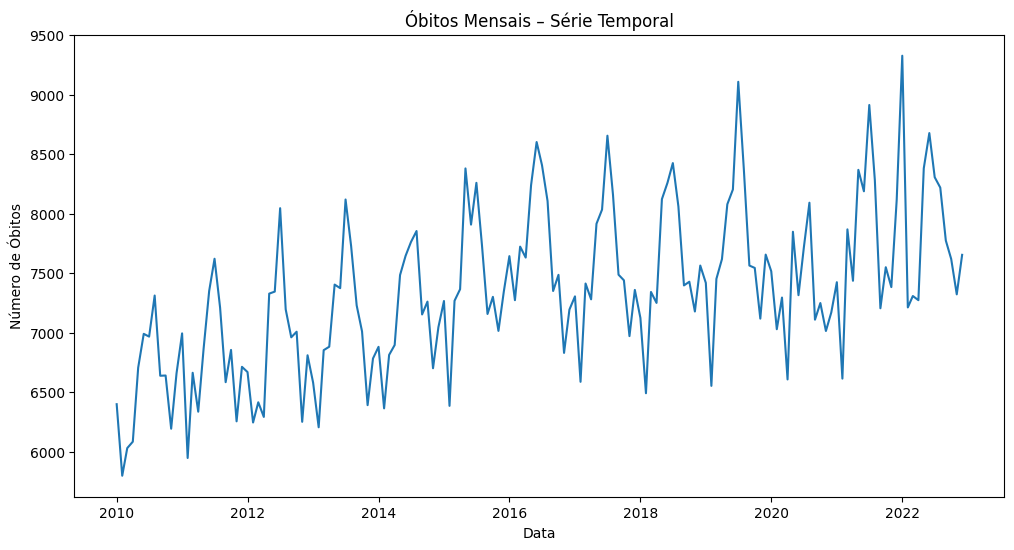

In [8]:
serie = carregar_series_temporal('dados_combinados.csv')


# Visualização inicial
plt.figure(figsize=(12, 6))
plt.plot(serie)
plt.title('Óbitos Mensais – Série Temporal')
plt.xlabel('Data')
plt.ylabel('Número de Óbitos')
plt.show()

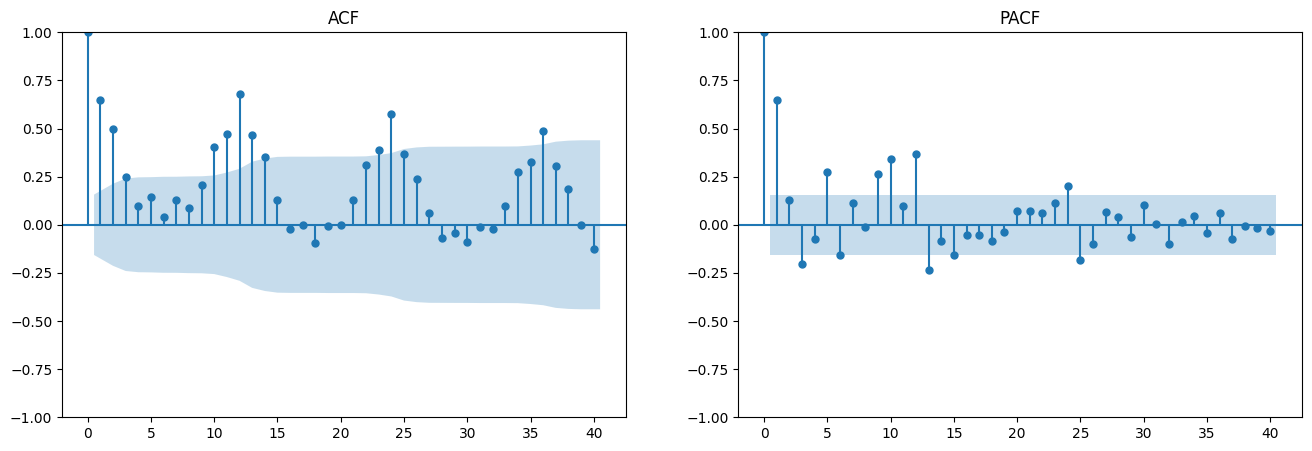

In [9]:
# ACF e PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
sm.graphics.tsa.plot_acf(serie, lags=40, ax=axes[0])
sm.graphics.tsa.plot_pacf(serie, lags=40, ax=axes[1], method='ywm')
axes[0].set_title('ACF')
axes[1].set_title('PACF')
plt.show()

In [10]:
os.makedirs("../Data/processed", exist_ok=True)

serie.to_csv("../Data/processed/serie_temporal_mensal.csv")

# 4. MODELO SARIMA

SARIMA → MSE: 192153.74 | MAPE: 3.63%


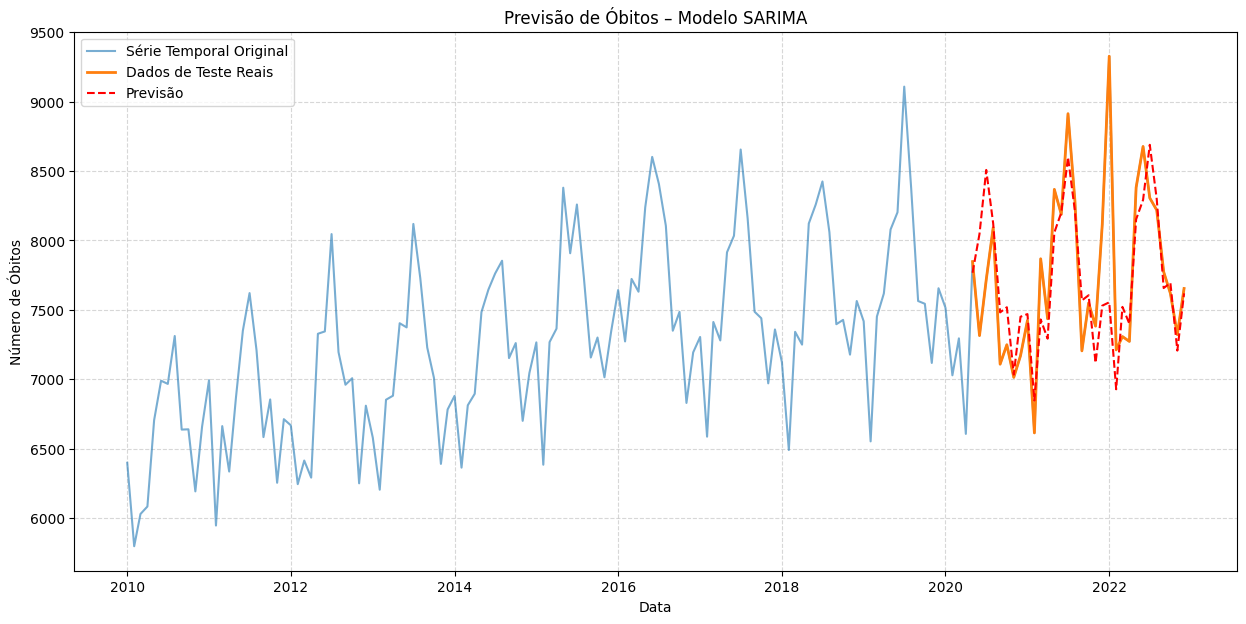

In [11]:
train, test = dividir_treino_teste(serie)


sarima = SARIMAX(
    train,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12)
    )


sarima_fit = sarima.fit(disp=False)
forecast_sarima = sarima_fit.get_forecast(steps=len(test)).predicted_mean


mse_sarima, mape_sarima = avaliar_modelo(test, forecast_sarima)


print(f'SARIMA → MSE: {mse_sarima:.2f} | MAPE: {mape_sarima:.2f}%')


plot_previsao(
    serie, test, forecast_sarima,
    'Previsão de Óbitos – Modelo SARIMA',
    cor_pred='red'
    )

In [12]:
previsao_sarima_df = pd.DataFrame({
    "data": forecast_sarima.index,
    "previsao": forecast_sarima.values
})

previsao_sarima_df.to_csv("../Data/processed/previsao_sarima.csv", index=False)

# 5. MODELO HOLT-WINTERS

Holt-Winters → MSE: 228542.52 | MAPE: 4.03%


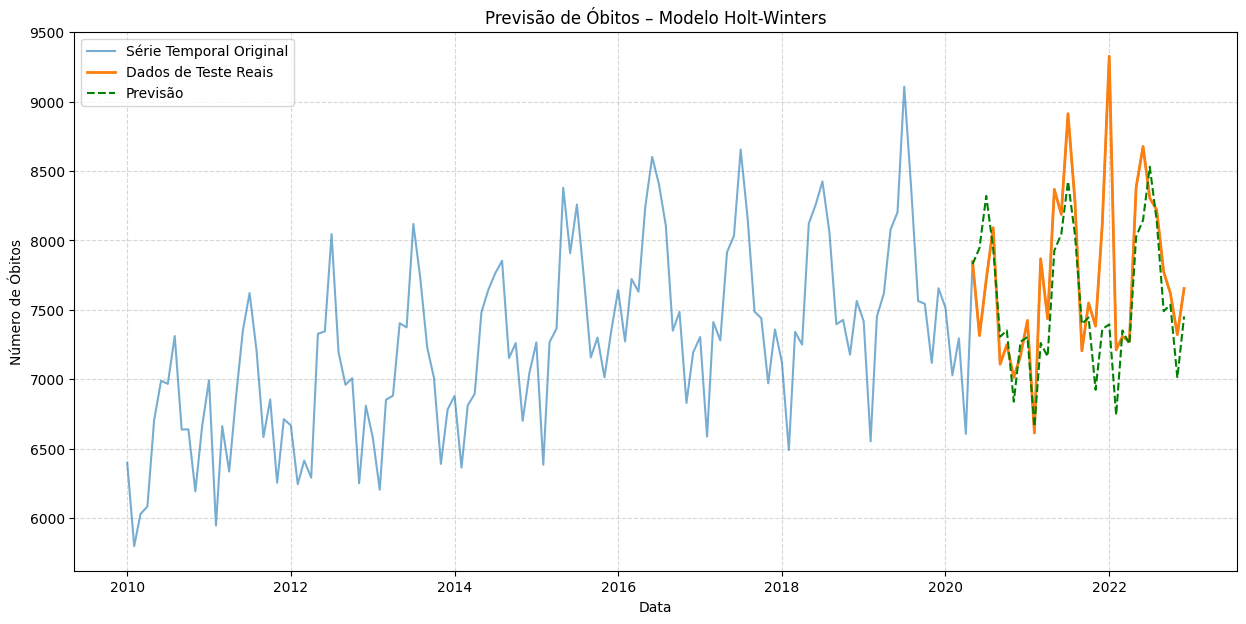

In [28]:
# Garantir índice correto
serie.index = pd.DatetimeIndex(serie.index)
serie = serie.asfreq('MS')

train_size = int(len(serie) * 0.8)
train, test = serie[:train_size], serie[train_size:]

hw_model = ExponentialSmoothing(
    train,
    trend='add',
    seasonal='mul',
    seasonal_periods=12
)

hw_fit = hw_model.fit()

forecast_hw = hw_fit.forecast(steps=len(test))

# 🔹 Garantir alinhamento
forecast_hw = pd.Series(forecast_hw.values, index=test.index)

mse_hw, mape_hw = avaliar_modelo(test.values, forecast_hw.values)

print(f'Holt-Winters → MSE: {mse_hw:.2f} | MAPE: {mape_hw:.2f}%')

plot_previsao(
    serie,
    test,
    forecast_hw,
    'Previsão de Óbitos – Modelo Holt-Winters',
    cor_pred='green'
)

In [ ]:
previsao_hw_df = pd.DataFrame({
    "data": forecast_hw.index,
    "previsao": forecast_hw.values
})

previsao_hw_df.to_csv("../Data/processed/previsao_holt_winters.csv", index=False)

# 6. MODELO LSTM (BASE)

### ADAM -   128/128/64/32/16/1 || 120/16

Epoch 1/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - loss: 0.0764 - val_loss: 0.0591
Epoch 2/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0613 - val_loss: 0.0701
Epoch 3/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0302 - val_loss: 0.0300
Epoch 4/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0292 - val_loss: 0.0467
Epoch 5/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0268 - val_loss: 0.0320
Epoch 6/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0258 - val_loss: 0.0373
Epoch 7/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0260 - val_loss: 0.0364
Epoch 8/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0283 - val_loss: 0.0327
Epoch 9/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0262 - val_loss: 0.0382
Epoch 10/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0249 - val_loss: 0.0318
Epoch 11/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0244 - val_loss: 0.0346
Epoch 12/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0238 - val_l

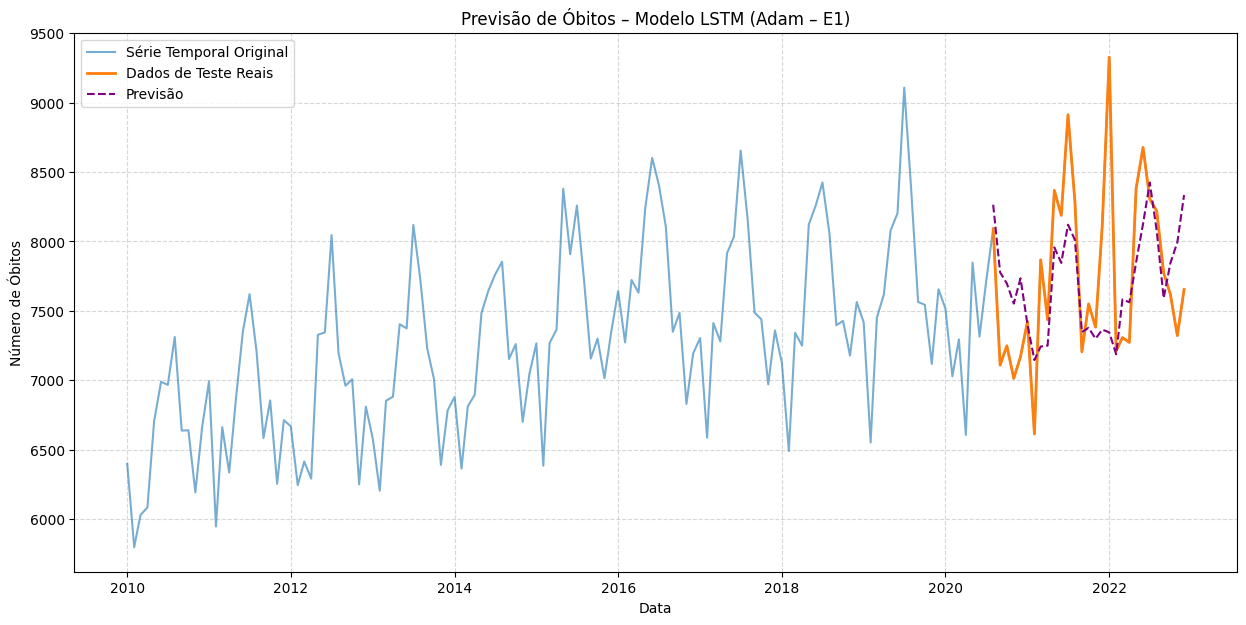

In [15]:
scaler = MinMaxScaler(feature_range=(0, 1))
serie_scaled = scaler.fit_transform(serie.values.reshape(-1, 1))

SEQ_LENGTH = 12
X, y = criar_sequencias(serie_scaled, SEQ_LENGTH)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

model_e1 = Sequential([
    Input(shape=(SEQ_LENGTH, 1)),
    LSTM(128, return_sequences=True),
    LSTM(128, return_sequences=True),
    LSTM(64),
    Dense(32),
    Dense(16),
    Dense(1)
])

optimizer_adam_e1 = Adam(learning_rate=0.001)

model_e1.compile(
    optimizer=optimizer_adam_e1,
    loss='mean_squared_error'
)

history_e1 = model_e1.fit(
    X_train, y_train,
    epochs=120,
    batch_size=16,
    validation_data=(X_test, y_test),
    verbose=1
)

pred_lstm = model_e1.predict(X_test)
pred_lstm_real = scaler.inverse_transform(pred_lstm)
y_test_real = scaler.inverse_transform(y_test.reshape(-1, 1))

mse_lstm, mape_lstm = avaliar_modelo(y_test_real, pred_lstm_real)
print(f'LSTM (Adam – E1) → MSE: {mse_lstm:.2f} | MAPE: {mape_lstm:.2f}%')

# 🔹 CORREÇÃO DO ÍNDICE TEMPORAL
total_obs = len(serie)
total_seq = total_obs - SEQ_LENGTH
split_index = int(total_seq * 0.8)

idx_test = serie.index[SEQ_LENGTH + split_index:]

# 🔹 Garantir mesmo tamanho
idx_test = idx_test[:len(pred_lstm_real)]

# 🔹 Criar DataFrame correto
df_lstm_adam = pd.DataFrame({
    "DATA": idx_test,
    "REAL": y_test_real.flatten(),
    "PREVISAO": pred_lstm_real.flatten()
})

# 🔹 Salvar CSV corretamente
import os
os.makedirs("../Data/processed", exist_ok=True)

df_lstm_adam.to_csv(
    "../Data/processed/previsao_lstm_adam.csv",
    index=False
)

plot_previsao(
    serie,
    pd.Series(y_test_real.flatten(), index=idx_test),
    pd.Series(pred_lstm_real.flatten(), index=idx_test),
    'Previsão de Óbitos – Modelo LSTM (Adam – E1)',
    cor_pred='purple'
)

### AdamW - 128/128/64/32/16/1 || 120/16

Epoch 1/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 108ms/step - loss: 0.0877 - val_loss: 0.0325
Epoch 2/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0361 - val_loss: 0.0373
Epoch 3/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0326 - val_loss: 0.0355
Epoch 4/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0294 - val_loss: 0.0456
Epoch 5/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.0270 - val_loss: 0.0314
Epoch 6/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0281 - val_loss: 0.0439
Epoch 7/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0264 - val_loss: 0.0317
Epoch 8/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0266 - val_loss: 0.0398
Epoch 9/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0253 - val_loss: 0.0341
Epoch 10/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0249 - val_loss: 0.0374
Epoch 11/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0251 - val_loss: 0.0320
Epoch 12/120
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0243 - val_l

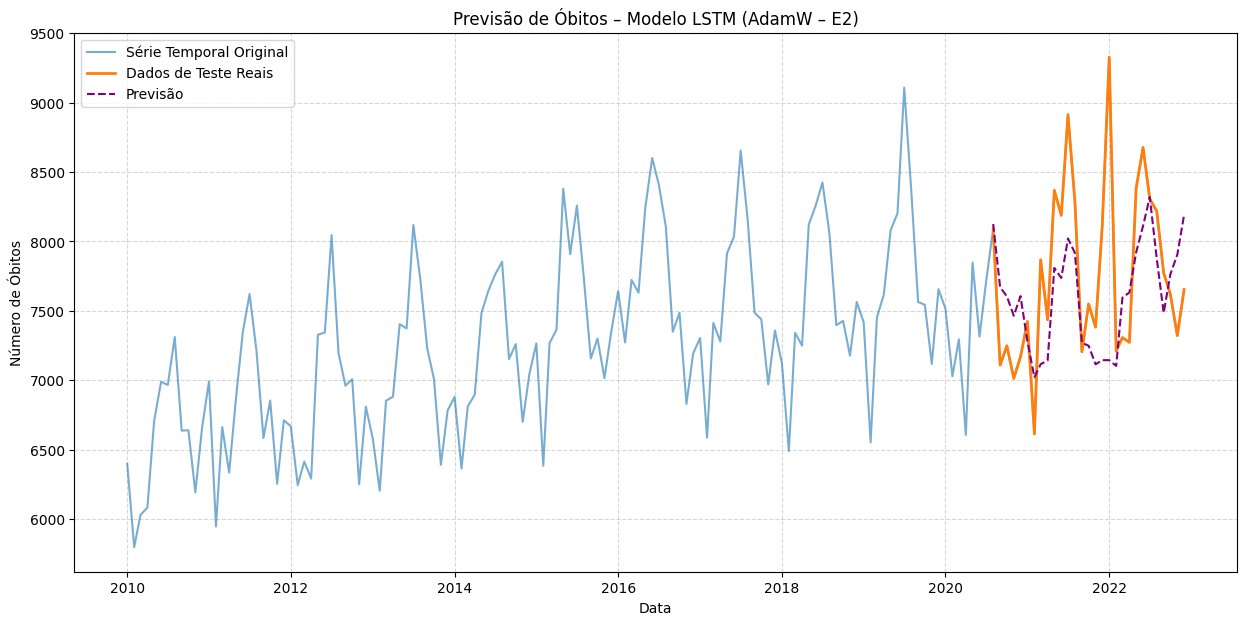

In [16]:
scaler = MinMaxScaler(feature_range=(0, 1))
serie_scaled = scaler.fit_transform(serie.values.reshape(-1, 1))

SEQ_LENGTH = 12
X, y = criar_sequencias(serie_scaled, SEQ_LENGTH)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

model_e2 = Sequential([
    Input(shape=(SEQ_LENGTH, 1)),
    LSTM(128, return_sequences=True),
    LSTM(128, return_sequences=True),
    LSTM(64),
    Dense(32),
    Dense(16),
    Dense(1)
])

optimizer_adamw_e2 = AdamW(
    learning_rate=0.001,
    weight_decay=0.004
)

model_e2.compile(
    optimizer=optimizer_adamw_e2,
    loss='mean_squared_error'
)

history_e2 = model_e2.fit(
    X_train, y_train,
    epochs=120,
    batch_size=16,
    validation_data=(X_test, y_test),
    verbose=1
)

pred_lstm = model_e2.predict(X_test)
pred_lstm_real = scaler.inverse_transform(pred_lstm)
y_test_real = scaler.inverse_transform(y_test.reshape(-1, 1))

mse_lstm, mape_lstm = avaliar_modelo(y_test_real, pred_lstm_real)
print(f'LSTM (AdamW – E2) → MSE: {mse_lstm:.2f} | MAPE: {mape_lstm:.2f}%')

# 🔹 Correção do índice temporal considerando o deslocamento do SEQ_LENGTH
total_obs = len(serie)
total_seq = total_obs - SEQ_LENGTH
split_index = int(total_seq * 0.8)

idx_test = serie.index[SEQ_LENGTH + split_index:]
idx_test = idx_test[:len(pred_lstm_real)]

# 🔹 Criar DataFrame final
df_lstm_adamw = pd.DataFrame({
    "DATA": idx_test,
    "REAL": y_test_real.flatten(),
    "PREVISAO": pred_lstm_real.flatten()
})

# 🔹 Garantir pasta
import os
os.makedirs("../Data/processed", exist_ok=True)

# 🔹 Salvar CSV
df_lstm_adamw.to_csv(
    "../Data/processed/previsao_lstm_adamw.csv",
    index=False
)

plot_previsao(
    serie,
    pd.Series(y_test_real.flatten(), index=idx_test),
    pd.Series(pred_lstm_real.flatten(), index=idx_test),
    'Previsão de Óbitos – Modelo LSTM (AdamW – E2)',
    cor_pred='purple'
)

### Adam - 64/32/16 || 60/32

Epoch 1/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 280ms/step - loss: 0.1698 - val_loss: 0.1386
Epoch 2/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step - loss: 0.0495 - val_loss: 0.0306
Epoch 3/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 275ms/step - loss: 0.0391 - val_loss: 0.0455
Epoch 4/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0403 - val_loss: 0.0307
Epoch 5/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 369ms/step - loss: 0.0268 - val_loss: 0.0489
Epoch 6/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - loss: 0.0321 - val_loss: 0.0553
Epoch 7/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 0.0316 - val_loss: 0.0440
Epoch 8/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0264 - val_loss: 0.0332
Epoch 9/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0263 - val_loss: 0.0304
Epoch 10/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0276 - val_loss: 0.0310
Epoch 11/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0263 - val_loss: 0.0345
Epoch 12/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0256 - val_loss: 0.0

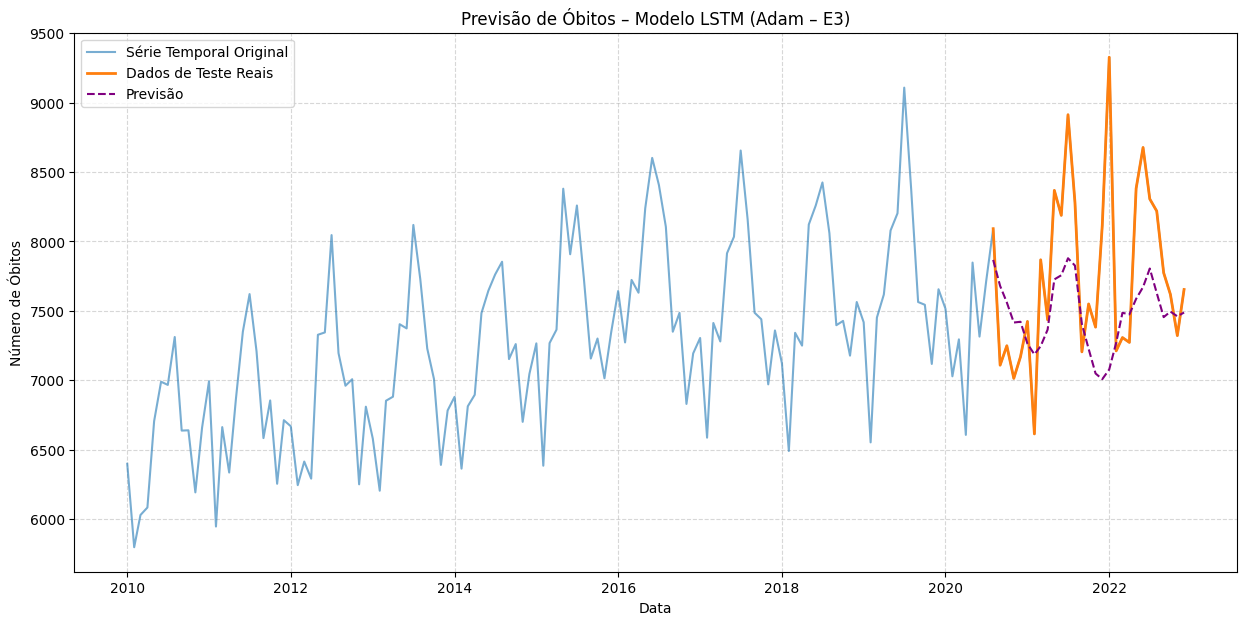

In [17]:
scaler = MinMaxScaler(feature_range=(0, 1))
serie_scaled = scaler.fit_transform(serie.values.reshape(-1, 1))

SEQ_LENGTH = 12
X, y = criar_sequencias(serie_scaled, SEQ_LENGTH)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

model_e3 = Sequential([
    Input(shape=(SEQ_LENGTH, 1)),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(16),
    Dense(1)
])

optimizer_adam_e3 = Adam(learning_rate=0.001)

model_e3.compile(
    optimizer=optimizer_adam_e3,
    loss='mean_squared_error'
)

history_e3 = model_e3.fit(
    X_train, y_train,
    epochs=60,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

pred_lstm = model_e3.predict(X_test)
pred_lstm_real = scaler.inverse_transform(pred_lstm)
y_test_real = scaler.inverse_transform(y_test.reshape(-1, 1))

mse_lstm, mape_lstm = avaliar_modelo(y_test_real, pred_lstm_real)
print(f'LSTM (Adam – E3) → MSE: {mse_lstm:.2f} | MAPE: {mape_lstm:.2f}%')

# 🔹 Correção do índice temporal considerando o deslocamento do SEQ_LENGTH
total_obs = len(serie)
total_seq = total_obs - SEQ_LENGTH
split_index = int(total_seq * 0.8)

idx_test = serie.index[SEQ_LENGTH + split_index:]
idx_test = idx_test[:len(pred_lstm_real)]

# 🔹 Criar DataFrame final
df_lstm_adam_e3 = pd.DataFrame({
    "DATA": idx_test,
    "REAL": y_test_real.flatten(),
    "PREVISAO": pred_lstm_real.flatten()
})

# 🔹 Garantir pasta
import os
os.makedirs("../Data/processed", exist_ok=True)

# 🔹 Salvar CSV
df_lstm_adam_e3.to_csv(
    "../Data/processed/previsao_lstm_adam_e3.csv",
    index=False
)

plot_previsao(
    serie,
    pd.Series(y_test_real.flatten(), index=idx_test),
    pd.Series(pred_lstm_real.flatten(), index=idx_test),
    'Previsão de Óbitos – Modelo LSTM (Adam – E3)',
    cor_pred='purple'
)

### AdamW - 64/32/16 || 60/32

Epoch 1/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 206ms/step - loss: 0.1725 - val_loss: 0.1547
Epoch 2/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0670 - val_loss: 0.0410
Epoch 3/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0311 - val_loss: 0.0396
Epoch 4/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0400 - val_loss: 0.0309
Epoch 5/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0279 - val_loss: 0.0360
Epoch 6/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0275 - val_loss: 0.0439
Epoch 7/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0288 - val_loss: 0.0429
Epoch 8/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0272 - val_loss: 0.0354
Epoch 9/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0256 - val_loss: 0.0315
Epoch 10/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0264 - val_loss: 0.0309
Epoch 11/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0264 - val_loss: 0.0327
Epoch 12/60
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0255 - val_loss: 0.0343


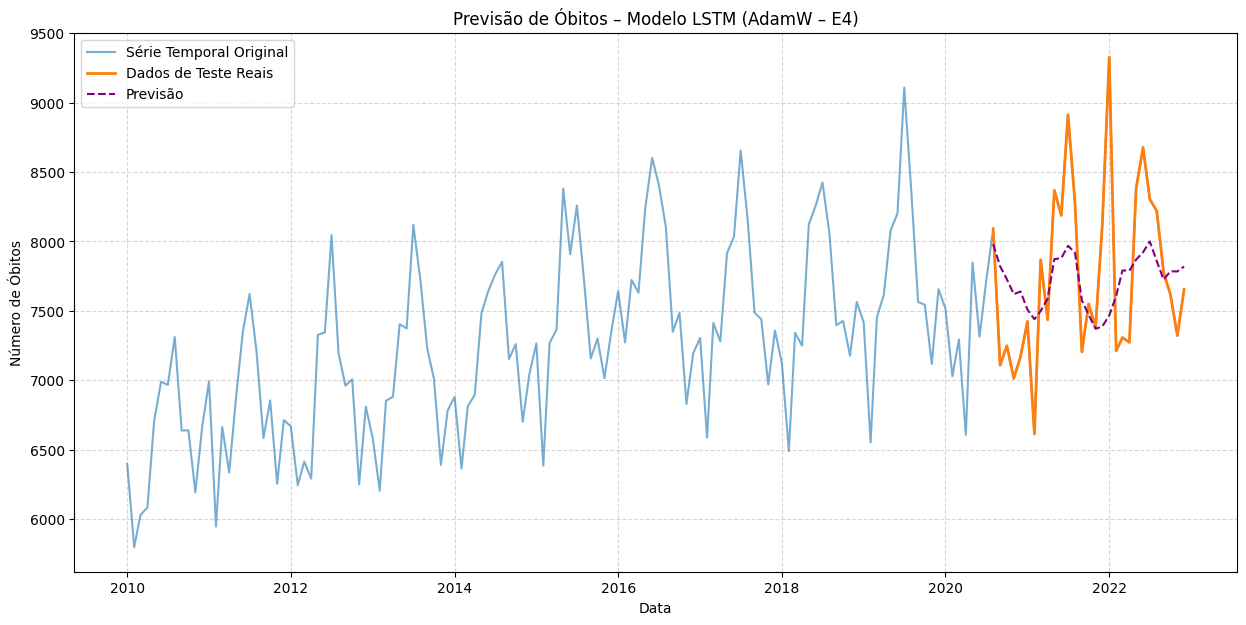

In [18]:
scaler = MinMaxScaler(feature_range=(0, 1))
serie_scaled = scaler.fit_transform(serie.values.reshape(-1, 1))

SEQ_LENGTH = 12
X, y = criar_sequencias(serie_scaled, SEQ_LENGTH)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

model_e4 = Sequential([
    Input(shape=(SEQ_LENGTH, 1)),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(16),
    Dense(1)
])

optimizer_adamw_e4 = AdamW(
    learning_rate=0.001,
    weight_decay=0.005
)

model_e4.compile(
    optimizer=optimizer_adamw_e4,
    loss='mean_squared_error'
)

history_e4 = model_e4.fit(
    X_train, y_train,
    epochs=60,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

pred_lstm = model_e4.predict(X_test)
pred_lstm_real = scaler.inverse_transform(pred_lstm)
y_test_real = scaler.inverse_transform(y_test.reshape(-1, 1))

mse_lstm, mape_lstm = avaliar_modelo(y_test_real, pred_lstm_real)
print(f'LSTM (AdamW – E4) → MSE: {mse_lstm:.2f} | MAPE: {mape_lstm:.2f}%')

# 🔹 Correção do índice considerando deslocamento da janela
total_obs = len(serie)
total_seq = total_obs - SEQ_LENGTH
split_index = int(total_seq * 0.8)

idx_test = serie.index[SEQ_LENGTH + split_index:]
idx_test = idx_test[:len(pred_lstm_real)]

# 🔹 DataFrame final padronizado
df_lstm_adamw_e4 = pd.DataFrame({
    "DATA": idx_test,
    "REAL": y_test_real.flatten(),
    "PREVISAO": pred_lstm_real.flatten()
})

# 🔹 Garantir pasta
import os
os.makedirs("../Data/processed", exist_ok=True)

# 🔹 Salvar CSV
df_lstm_adamw_e4.to_csv(
    "../Data/processed/previsao_lstm_adamw_e4.csv",
    index=False
)

plot_previsao(
    serie,
    pd.Series(y_test_real.flatten(), index=idx_test),
    pd.Series(pred_lstm_real.flatten(), index=idx_test),
    'Previsão de Óbitos – Modelo LSTM (AdamW – E4)',
    cor_pred='purple'
)

# 7. COMPARAÇÃO FINAL

In [19]:
def avaliar(model, X_test, y_test, scaler):
    pred = model.predict(X_test)
    pred_real = scaler.inverse_transform(pred)
    y_real = scaler.inverse_transform(y_test.reshape(-1, 1))

    mse = np.mean((y_real - pred_real) ** 2)
    mape = np.mean(np.abs((y_real - pred_real) / y_real)) * 100
    return mse, mape

In [21]:
resultados_lstm = {
    'LSTM Adam (E1)': avaliar(model_e1, X_test, y_test, scaler),
    'LSTM AdamW (E2)': avaliar(model_e2, X_test, y_test, scaler),
    'LSTM Adam (E3)': avaliar(model_e3, X_test, y_test, scaler),
    'LSTM AdamW (E4)': avaliar(model_e4, X_test, y_test, scaler)
}


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


In [26]:
df_lstm = pd.DataFrame([
    {'Modelo': modelo, 'MSE': mse, 'MAPE (%)': mape}
    for modelo, (mse, mape) in resultados_lstm.items()
])

In [27]:
df_classicos = pd.DataFrame([
    {'Modelo': 'SARIMA', 'MSE': mse_sarima, 'MAPE (%)': mape_sarima},
    {'Modelo': 'Holt-Winters', 'MSE': mse_hw, 'MAPE (%)': mape_hw}
])

In [29]:
resultados_finais = pd.concat(
    [df_classicos, df_lstm],
    ignore_index=True
)

resultados_finais.to_csv("../Data/processed/metricas_modelos.csv", index=False)

In [30]:
print('\n📊 Comparação Final dos Modelos:')
display(
    resultados_finais.sort_values('MAPE (%)').reset_index(drop=True)
)


📊 Comparação Final dos Modelos:


,Modelo,MSE,MAPE (%)
0,SARIMA,192153.742577,3.630998
1,Holt-Winters,268546.203501,4.545009
2,LSTM Adam (E1),320897.291885,5.395516
3,LSTM AdamW (E2),365319.086413,5.693835
4,LSTM AdamW (E4),333276.560578,5.752664
5,LSTM Adam (E3),425516.355077,5.983277
